# Notebook to investigate how to build the "task change detector"

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
dtype = torch.float32

In [6]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [7]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [8]:
data_path = './Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [9]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

## Get train-val-test split

In [10]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= target_variable, no_outliers = False, force_data = True)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


In [11]:
baseline_df_sim = baseline_df.copy()

In [12]:
sim_data_path = './Data/Processed_Data/Simulated_50_'+name+'_'+date+'.pkl'

with open(sim_data_path, 'rb') as file:
    sim_data = pickle.load(file)

In [13]:
baseline_df_sim['both_rates'] = sim_data['Set_0'].tolist()

In [14]:
xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, fold, target_variable= target_variable, no_outliers = False, force_data = True)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


## Building the RNN model and Sequence Generator to predict X_t+1 from X_t

In [15]:
class SequenceDataset(Dataset):

    def __init__(self, X, sequence_length=10):
        """
        Initializes the SequenceDataset.
        
        Args:
            X (torch.Tensor): The input sequences.
            sequence_length (int): The desired length of each sequence.
        """
        self.sequence_length = sequence_length
        self.X = torch.tensor(X)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.X.shape[0] * (self.X.shape[1] - self.sequence_length)

    def __getitem__(self, i): 
        """
        Gets the i-th sample from the dataset.
        
        Args:
            i (int): Index of the desired sample.
        
        Returns:
            xx (torch.Tensor): Input sequence of length sequence_length.
            yy (torch.Tensor): Target for the next time step.
        """
        trial_index = i // (self.X.shape[1] - self.sequence_length)
        point_index = i % (self.X.shape[1] - self.sequence_length)
        
        xx = self.X[trial_index, point_index:point_index+self.sequence_length, :]
        yy = self.X[trial_index, point_index+self.sequence_length, :]
        
        return xx, yy


In [16]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Task_Change'
if not os.path.exists(path_to_models):
    os.makedirs(path_to_models)
    print(f"Folder '{path_to_models}' created.")
# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [17]:
class Test_RNN(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                output_size = 6):
        super(Test_RNN, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size = self.num_features, 
            hidden_size = self.hidden_units, 
            num_layers = self.num_layers, 
            nonlinearity='tanh', bias= True, 
            batch_first= True, dropout=0.0, 
            bidirectional=False,)  
        
        self.fc = nn.Linear(hidden_units, output_size)

        # Flatten the parameters
        self.rnn.flatten_parameters()

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(x[:, -1, :])

        return out.squeeze()

In [18]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

In [19]:
model = Test_RNN(num_features, hidden_units, num_layers, num_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of SequenceDataset
train_dataset = SequenceDataset(xx_train_base)  # Assuming you have X_train defined
val_dataset = SequenceDataset(xx_val_base)  # Assuming you have X_train defined

loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in loader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader_val:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(loader_val)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}")

# Save the trained model
#torch.save(model.state_dict(), 'rnn_model.pth')

Epoch 1/100, Train Loss: 0.056333206593990326, Val Loss: 0.07659434177437607
Epoch 2/100, Train Loss: 0.025299448519945145, Val Loss: 0.035039170835243195
Epoch 3/100, Train Loss: 0.01840342953801155, Val Loss: 0.023171323370568608
Epoch 4/100, Train Loss: 0.01287140790373087, Val Loss: 0.017677750628517598
Epoch 5/100, Train Loss: 0.010034867562353611, Val Loss: 0.014131860465419536
Epoch 6/100, Train Loss: 0.00809306837618351, Val Loss: 0.012008560241713208
Epoch 7/100, Train Loss: 0.006808824371546507, Val Loss: 0.010455271115108413
Epoch 8/100, Train Loss: 0.007502506487071514, Val Loss: 0.00935668310112491
Epoch 9/100, Train Loss: 0.005750604439526796, Val Loss: 0.00840093346540721
Epoch 10/100, Train Loss: 0.005865165963768959, Val Loss: 0.007795230475995614
Epoch 11/100, Train Loss: 0.005588226951658726, Val Loss: 0.007210893865332616
Epoch 12/100, Train Loss: 0.004338730592280626, Val Loss: 0.006708784100162435
Epoch 13/100, Train Loss: 0.004232028964906931, Val Loss: 0.0067289

In [27]:
import matplotlib.pyplot as plt

# Load test data and create DataLoader
test_dataset = SequenceDataset(xx_test_base)  # Assuming you have X_test defined
test_loader = data.DataLoader(test_dataset, batch_size=batch_size_train)

# Evaluate the model on the test data
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
        predictions.extend(outputs.tolist())
        ground_truth.extend(targets.tolist())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")



Test Loss: 0.004503383193301355


In [28]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(ground_truth, predictions)
print(f"R-squared: {r2}")

R-squared: 0.9954105363376182


In [29]:
# Convert predictions and ground truth to numpy arrays for visualization
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

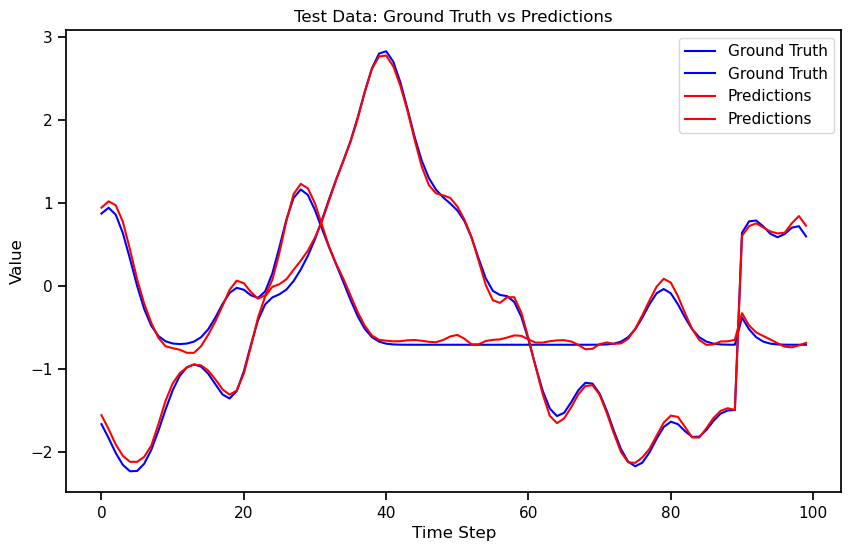

In [30]:


# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(ground_truth[:100, 5:7], label='Ground Truth', color='blue')
plt.plot(predictions[:100, 5:7], label='Predictions', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Ground Truth vs Predictions')
plt.legend()
plt.show()


### Test model on simulated data

In [31]:
import matplotlib.pyplot as plt

# Load test data and create DataLoader
test_dataset = SequenceDataset(xx_test_sim)  # Assuming you have X_test defined
test_loader = data.DataLoader(test_dataset, batch_size=batch_size_train)

# Evaluate the model on the test data
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.float()  # Convert input data to torch.float32
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
        predictions.extend(outputs.tolist())
        ground_truth.extend(targets.tolist())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

# Convert predictions and ground truth to numpy arrays for visualization
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)


Test Loss: 0.0040217833842506835


In [32]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(ground_truth, predictions)
print(f"R-squared: {r2}")

R-squared: 0.8655573277777538


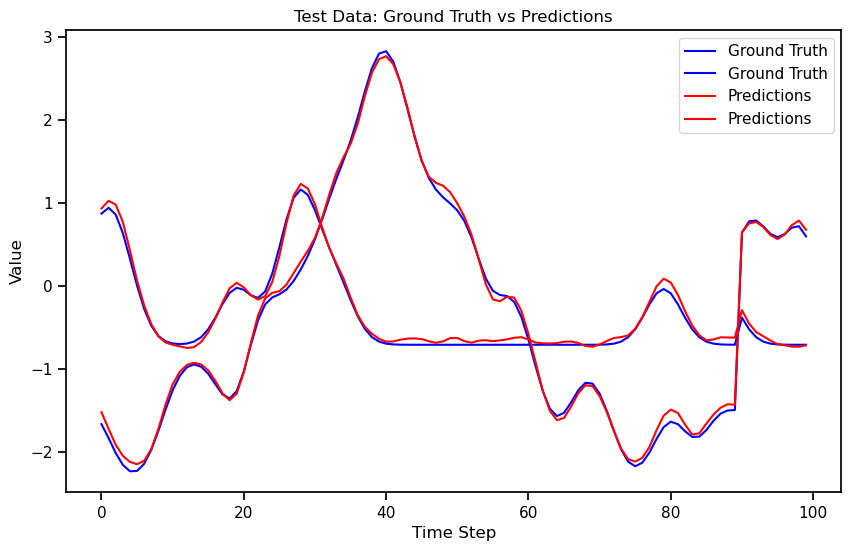

In [33]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(ground_truth[:100, 5:7], label='Ground Truth', color='blue')
plt.plot(predictions[:100, 5:7], label='Predictions', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Ground Truth vs Predictions')
plt.legend()
plt.show()